In [21]:
# create 5-fold cross validation files for CycPeptMPDB regression data
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

# load cycpeptmpdb_regression.csv
cycpeptmpdb_regression_df = pd.read_csv("training_data/regression_data/cycpeptmpdb_regression.csv")
print(len(cycpeptmpdb_regression_df))
cycpeptmpdb_regression_df

# print average smiles length
print("Average SMILES length: ", cycpeptmpdb_regression_df["SMILES"].apply(len).mean())

# print average pampa
print("Average PAMPA: ", cycpeptmpdb_regression_df["PAMPA"].mean())

# print number of PAMPA >= -5.5
print("Number of PAMPA >= -5.5: ", len(cycpeptmpdb_regression_df[cycpeptmpdb_regression_df["PAMPA"] >= -5.5]))

# print number of PAMPA < -5.5
print("Number of PAMPA < -5.5: ", len(cycpeptmpdb_regression_df[cycpeptmpdb_regression_df["PAMPA"] < -5.5]))


6941
Average SMILES length:  150.7055179368967
Average PAMPA:  -5.86626422705662
Number of PAMPA >= -5.5:  2854
Number of PAMPA < -5.5:  4087


In [20]:
cycpeptmpdb_regression_df = cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['PAMPA'] != -10].reset_index(drop=True)
print(len(cycpeptmpdb_regression_df))


6701
Average SMILES length:  151.45575287270557
Average PAMPA:  -5.718212207133264


In [ ]:
# Import libraries
from collections import OrderedDict
import pandas as pd
import torch
from roformer import RoFormerForMaskedLM, RoFormerConfig #, RoFormerForMaskedLM,
from tokenizer.my_tokenizers import SMILES_SPE_Tokenizer


In [ ]:
# Load tokenizer #################################################################
vocab_file = 'tokenizer/new_vocab.txt'
splits_file = 'tokenizer/new_splits.txt'

tokenizer = SMILES_SPE_Tokenizer(vocab_file, splits_file)

# set model configuration ###############################################################
config = RoFormerConfig(
    vocab_size=tokenizer.vocab_size,
    embedding_size=768,
    max_position_embeddings=768,
    num_hidden_layers=6,
    num_attention_heads=12,
    hidden_size=768,
    intermediate_size=3072,
    type_vocab_size=2,
    pad_token_id=tokenizer.pad_token_id,
    is_decoder=False,
    num_labels=1,
    hidden_dropout_prob=0,
    attention_probs_dropout_prob=0,
    problem_type='regression'
)

model = RoFormerForMaskedLM(config=config)
# model = reset_parameters(model)

# Define checkpoints ###############################################################
pretraining_checkpoint = 'checkpoints/2024-05-28_FirstPepLM_onRandom_peps/pepLM-epoch=09-step=412739-val_loss=0.292.ckpt'
checkpoint = pretraining_checkpoint
checkpoint_data = torch.load(checkpoint, map_location='cpu')

new_state_dict = OrderedDict()
for k, v in checkpoint_data['state_dict'].items():
    name = k[6:]
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.eval()

In [ ]:
# Encode data ####################################################################
# model and data to cuda
model.to('cuda')
model.eval()


def encode_data(data, tokenizer):
    encoded_data = []
    for i, row in data.iterrows():
        smiles = row['SMILES']
        encoded = tokenizer.encode_plus(smiles, return_tensors='pt')
        encoded_data.append(encoded)
    return encoded_data

encoded_data = encode_data(cycpeptmpdb_regression_df, tokenizer)
encoded_data

In [14]:
from tqdm import tqdm

# encoded_data to cuda
for encoded in encoded_data:
    for k, v in encoded.items():
        encoded[k] = v.to('cuda')

# only use GPU 1-6
# torch.cuda.set_device(0)

cls_embeddings = []

for encoded in tqdm(encoded_data[:]):
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, return_dict=True, output_hidden_states=True)
    cls_embeddings.append(outputs.hidden_states[-1][0][0])


100%|██████████| 6701/6701 [00:39<00:00, 169.24it/s]


In [ ]:
# cls_embeddings

# make embeddings a list
# embeddings = [cls_embedding.cpu().numpy() for cls_embedding in cls_embeddings]


In [19]:
# add embeddings to dataframe
# cycpeptmpdb_regression_df['embeddings'] = embeddings

# save to csv
# cycpeptmpdb_regression_df.to_csv('training_data/regression_data/cycpeptmpdb_embeddings.csv', index=False)


In [63]:
import pandas as pd

cycpeptmpdb_regression_df = pd.read_csv('training_data/regression_data/cycpeptmpdb_embeddings.csv')
cycpeptmpdb_regression_df.head()

,SMILES,PAMPA,embeddings
0,CCCN1CC(=O)N(C)[C@@H](CC(C)C)C(=O)N(Cc2ccccc2)...,-5.13,[-2.99394250e-01 8.25379670e-01 7.30068266e-...
1,CC(C)C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](Cc2...,-4.85,[-4.32275325e-01 5.68822443e-01 2.56158233e-...
2,CC(=O)N[C@@H]1C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](C...,-5.31,[-6.50843501e-01 5.40750563e-01 8.18406761e-...
3,COc1ccc(C[C@@H]2NC(=O)[C@@H](Cc3cccc4ccccc34)N...,-6.85,[-3.90417576e-01 6.94390237e-01 6.20261073e-...
4,CC(=O)N1CCC[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N...,-6.68,[-4.57799077e-01 7.53796101e-01 5.57022512e-...


In [64]:
embeddings = cycpeptmpdb_regression_df['embeddings']

embeddings = embeddings.apply(lambda x: [float(i) for i in x.strip('[]').split()]).tolist()

cycpeptmpdb_regression_df['embeddings'] = embeddings
cycpeptmpdb_regression_df

,SMILES,PAMPA,embeddings
0,CCCN1CC(=O)N(C)[C@@H](CC(C)C)C(=O)N(Cc2ccccc2)...,-5.13,"[-0.29939425, 0.82537967, 0.730068266, -0.1674..."
1,CC(C)C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](Cc2...,-4.85,"[-0.432275325, 0.568822443, 0.256158233, 0.052..."
2,CC(=O)N[C@@H]1C(=O)N2CCC[C@H]2C(=O)N(C)[C@H](C...,-5.31,"[-0.650843501, 0.540750563, 0.818406761, -0.38..."
3,COc1ccc(C[C@@H]2NC(=O)[C@@H](Cc3cccc4ccccc34)N...,-6.85,"[-0.390417576, 0.694390237, 0.620261073, -0.19..."
4,CC(=O)N1CCC[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N...,-6.68,"[-0.457799077, 0.753796101, 0.557022512, -0.50..."
...,...,...,...
6696,CC(C)C[C@@H]1NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H]...,-7.70,"[-0.584741294, 1.29619789, 1.00702393, 0.06152..."
6697,CC(C)C[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC(C...,-5.41,"[-0.617715776, 0.798639417, 0.483992904, 0.208..."
6698,CC(=O)N1CCC[C@@H]1C(=O)N(C)[C@H](CC(C)C)C(=O)N...,-6.41,"[-0.687291443, 0.944678128, 0.724095106, -0.43..."
6699,CC(C)C[C@H]1NC(=O)[C@H](C(C)C)NC(=O)[C@@H](CC(...,-5.67,"[-0.290159494, 0.563955605, 0.514146149, -0.03..."


In [65]:
# conduct PCA on embeddings
from sklearn.decomposition import PCA

# select top embeddings that describe 90% of the data
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
cycpeptmpdb_regression_df['2_embeddings_pca'] = embeddings_pca.tolist()

pca = PCA(n_components=0.99)
embeddings_pca = pca.fit_transform(embeddings)
cycpeptmpdb_regression_df['embeddings_pca'] = embeddings_pca.tolist()
len(cycpeptmpdb_regression_df['embeddings_pca'][0])


153

In [16]:
import sklearn.cluster as cluster
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# data = np.array(embeddings)
data = np.array(embeddings_pca)

silhouette_score_hodler = []
number_of_clusters = 6

# run through random state 0-100 and get the best silhouette score
for i in range(20):
    # cluster_labels = MiniBatchKMeans(n_clusters=number_of_clusters, random_state=i, n_init='auto').fit_predict(data)
    cluster_labels = cluster.KMeans(n_clusters=number_of_clusters, random_state=i, n_init='auto').fit_predict(data)
    silhouette_score_value = silhouette_score(data, cluster_labels)
    
    silhouette_score_hodler.append(silhouette_score_value)
    print(f'n: {i}, s.score: {silhouette_score_value}')

# rerun the best silhouette score
best_silhouette_score_index = silhouette_score_hodler.index(max(silhouette_score_hodler))
print(f'best_silhouette_score_index: {best_silhouette_score_index}')
# cluster_labels = MiniBatchKMeans(n_clusters=number_of_clusters, random_state=best_silhouette_score_index, n_init='auto').fit_predict(data)
cluster_labels = cluster.KMeans(n_clusters=number_of_clusters, random_state=best_silhouette_score_index, n_init='auto').fit_predict(data)
print(silhouette_score(data, cluster_labels))

cycpeptmpdb_regression_df['cluster'] = cluster_labels
# cycpeptmpdb_regression_df
# value counts
cycpeptmpdb_regression_df['cluster'].value_counts()


n: 0, s.score: 0.24486680074287057
n: 1, s.score: 0.2448575671703162
n: 2, s.score: 0.24484363232091685
n: 3, s.score: 0.17606851672285054
n: 4, s.score: 0.24486680074287057
n: 5, s.score: 0.24486680074287057
n: 6, s.score: 0.2448367486975556
n: 7, s.score: 0.20999590323155937
n: 8, s.score: 0.1785538416549793
n: 9, s.score: 0.19707745029985155
n: 10, s.score: 0.2099712382659219
n: 11, s.score: 0.23042671618299207
n: 12, s.score: 0.1758695520364964
n: 13, s.score: 0.2448594398290522
n: 14, s.score: 0.24487397664437863
n: 15, s.score: 0.24486680074287057
n: 16, s.score: 0.23042671618299207
n: 17, s.score: 0.24483871955881778
n: 18, s.score: 0.24486680074287057
n: 19, s.score: 0.22385987159072543
best_silhouette_score_index: 14
0.24487397664437863


cluster
0    1547
2    1465
4    1443
3    1221
1     535
5     490
Name: count, dtype: int64

In [44]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Assuming your embeddings_pca is already defined as numpy array
# data = np.array(embeddings)
data = np.array(embeddings_pca)

silhouette_score_holder = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
inertia_holder = []

number_of_clusters = 6

# Run through random state 0-20 and get the best silhouette score
for i in [2]:#range(20):
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=i, n_init='auto')
    cluster_labels = kmeans.fit_predict(data)
    
    # Calculate silhouette score
    silhouette_score_value = silhouette_score(data, cluster_labels)
    silhouette_score_holder.append(silhouette_score_value)
    
    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(data, cluster_labels)
    davies_bouldin_scores.append(db_index)
    
    # Calculate Calinski-Harabasz Index
    ch_index = calinski_harabasz_score(data, cluster_labels)
    calinski_harabasz_scores.append(ch_index)
    
    # Save inertia (within-cluster sum of squares)
    inertia_holder.append(kmeans.inertia_)
    
    # print count of each cluster
    print(f'Cluster count: {np.bincount(cluster_labels)}')

    # Print the scores for each iteration
    # print(f'n: {i}, s.score: {silhouette_score_value}, DB Index: {db_index}, CH Index: {ch_index}, Inertia: {kmeans.inertia_}')

# Find the best silhouette score and rerun KMeans with the corresponding random state
best_silhouette_score_index = silhouette_score_holder.index(max(silhouette_score_holder))
print(f'Best silhouette score index: {best_silhouette_score_index}')
# print(f'Best silhouette score: {silhouette_score_holder[best_silhouette_score_index]}')

# Rerun KMeans with the best random state
best_kmeans = KMeans(n_clusters=number_of_clusters, random_state=2, n_init='auto')
cluster_labels = best_kmeans.fit_predict(data)

# Print the final silhouette score, Davies-Bouldin Index, and Calinski-Harabasz Index for the best model
final_silhouette = silhouette_score(data, cluster_labels)
final_davies_bouldin = davies_bouldin_score(data, cluster_labels)
final_calinski_harabasz = calinski_harabasz_score(data, cluster_labels)

# print(f'Final Silhouette Score: {final_silhouette}')
# print(f'Final Davies-Bouldin Index: {final_davies_bouldin}')
# print(f'Final Calinski-Harabasz Index: {final_calinski_harabasz}')
# print(f'Final Inertia: {best_kmeans.inertia_}')

# Save the cluster labels to the DataFrame
cycpeptmpdb_regression_df['cluster'] = cluster_labels

# Print value counts of clusters
print(cycpeptmpdb_regression_df['cluster'].value_counts())


Cluster count: [ 535 1206 1465  494 1546 1455]
Best silhouette score index: 0
cluster
4    1546
2    1465
5    1455
1    1206
0     535
3     494
Name: count, dtype: int64


In [28]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import time

# Assuming your embeddings_pca is already defined as numpy array
data = np.array(embeddings_pca)

# Range of clusters to try
# cluster range of 2-10
cluster_range = [2,3,4,5,6,7,8,9,10]  # Try 2 to 10 clusters
random_states = range(20)  # Try 20 random states for each algorithm
algorithms = {
    "KMeans": KMeans,
    "MiniBatchKMeans": MiniBatchKMeans,
    "AgglomerativeClustering": AgglomerativeClustering
}

# DataFrame to store results for each algorithm, number of clusters, and random state
results = pd.DataFrame(columns=['Algorithm', 'n_clusters', 'Random_State', 
                                'Silhouette_Score', 'Davies_Bouldin_Index', 
                                'Calinski_Harabasz_Index', 'Inertia', 'Time_Taken'])

# Pipeline to loop through each algorithm and each number of clusters
for algo_name, algo in algorithms.items():
    print(f"Starting clustering with {algo_name}")
    
    for n_clusters in cluster_range:
        for random_state in random_states:
            start_time = time.time()  # Start timing
            
            if algo_name == "AgglomerativeClustering":
                # AgglomerativeClustering doesn't support random_state or inertia
                model = algo(n_clusters=n_clusters)
            else:
                model = algo(n_clusters=n_clusters, random_state=random_state, n_init='auto')

            # Fit the model and get labels
            cluster_labels = model.fit_predict(data)
            
            # Calculate metrics
            silhouette_score_value = silhouette_score(data, cluster_labels)
            db_index = davies_bouldin_score(data, cluster_labels)
            ch_index = calinski_harabasz_score(data, cluster_labels)
            
            # Inertia is only available for KMeans-based algorithms
            inertia_value = model.inertia_ if hasattr(model, 'inertia_') else np.nan
            
            end_time = time.time()  # End timing
            time_taken = end_time - start_time  # Calculate time taken for clustering
            
            # Print progress for each method
            print(f"Algorithm: {algo_name}, n_clusters: {n_clusters}, random_state: {random_state}, "
                  f"Time Taken: {time_taken:.4f} seconds, Silhouette Score: {silhouette_score_value:.4f}")
            
            # Create a new row of results
            new_row = pd.DataFrame({
                'Algorithm': [algo_name],
                'n_clusters': [n_clusters],
                'Random_State': [random_state],
                'Silhouette_Score': [silhouette_score_value],
                'Davies_Bouldin_Index': [db_index],
                'Calinski_Harabasz_Index': [ch_index],
                'Inertia': [inertia_value],
                'Time_Taken': [time_taken]
            })

            # Concatenate the new row to the results DataFrame
            results = pd.concat([results, new_row], ignore_index=True)

            # print counts of clusters
            # print(pd.Series(cluster_labels).value_counts())
            
            if algo_name == "AgglomerativeClustering":
                break
            
    print(f"Finished clustering with {algo_name}\n")

# Finding the best combination of algorithm, cluster number, and random state
best_result = results.loc[results['Silhouette_Score'].idxmax()]
print(f"Best Algorithm: {best_result['Algorithm']}")
print(f"Best Number of Clusters: {best_result['n_clusters']}")
print(f"Best Random State: {best_result['Random_State']}")
print(f"Best Silhouette Score: {best_result['Silhouette_Score']}")
print(f"Best Davies-Bouldin Index: {best_result['Davies_Bouldin_Index']}")
print(f"Best Calinski-Harabasz Index: {best_result['Calinski_Harabasz_Index']}")
print(f"Best Inertia: {best_result['Inertia']}")

# Rerun the best configuration
if best_result['Algorithm'] == "AgglomerativeClustering":
    best_model = AgglomerativeClustering(n_clusters=int(best_result['n_clusters']))
else:
    best_model = algorithms[best_result['Algorithm']](n_clusters=int(best_result['n_clusters']),
                                                      random_state=int(best_result['Random_State']),
                                                      n_init='auto')

# Fit the best model and get the cluster labels
cluster_labels = best_model.fit_predict(data)

# Save the cluster labels to the DataFrame (cycpeptmpdb_regression_df)
cycpeptmpdb_regression_df['cluster'] = cluster_labels

print(results.head())
# save to csv
results.to_csv('training_data/regression_data/cycpeptmpdb_clustering_analysis_results(2to10_allAlgos_PC99%).csv', index=False)

Starting clustering with KMeans
Algorithm: KMeans, n_clusters: 2, random_state: 0, Time Taken: 0.9441 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2, random_state: 1, Time Taken: 0.5067 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2, random_state: 2, Time Taken: 0.5182 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2, random_state: 3, Time Taken: 0.4815 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2, random_state: 4, Time Taken: 0.5212 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2, random_state: 5, Time Taken: 0.5152 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2, random_state: 6, Time Taken: 0.5164 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2, random_state: 7, Time Taken: 0.4893 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2, random_state: 8, Time Taken: 0.4988 seconds, Silhouette Score: 0.2614
Algorithm: KMeans, n_clusters: 2

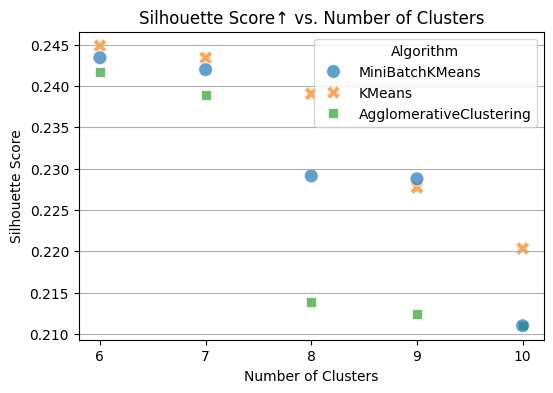

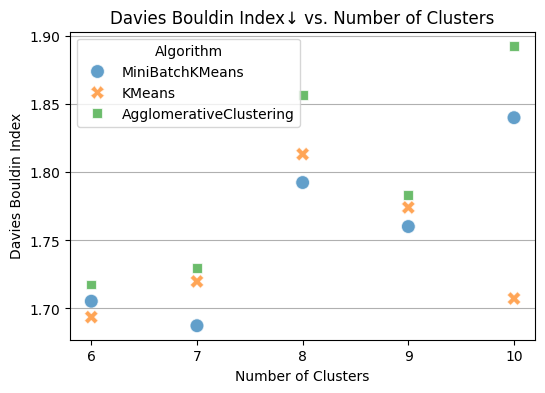

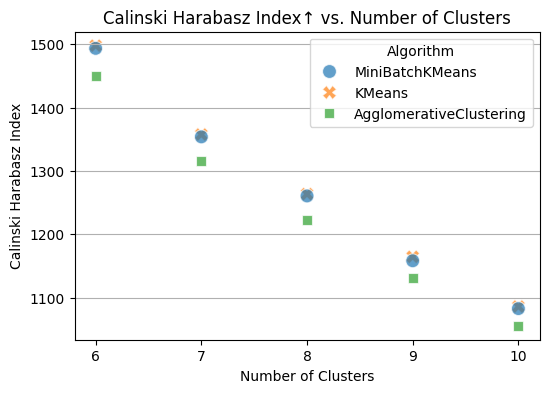

In [53]:
# plot results of clustering
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results DataFrame
results = pd.read_csv('training_data/regression_data/cycpeptmpdb_clustering_analysis_results(2to10_allAlgos_PC99%).csv')

all_metrics = ['Silhouette_Score', 'Davies_Bouldin_Index', 'Calinski_Harabasz_Index']#, 'Inertia']

# create up arrow and down arrow tokens
up_arrow = u'\u2191'
down_arrow = u'\u2193'

# remove rows that have 5 or less clusters
results = results[results['n_clusters'] > 5]

for metric in all_metrics:
    sort_by = metric
    # keep only the top scoring Random_State for each algorithm and n_clusters
    if sort_by == 'Davies_Bouldin_Index':
        results_top = results.loc[results.groupby(['Algorithm', 'n_clusters'])[sort_by].idxmin()]
        direction = down_arrow
    elif sort_by == 'Inertia':
        # remove rows with model 'AgglomerativeClustering' as it does not have inertia
        results_top = results[results['Algorithm'] != 'AgglomerativeClustering']
        results_top = results_top.loc[results_top.groupby(['Algorithm', 'n_clusters'])[sort_by].idxmin()]
        direction = down_arrow
    else:
        results_top = results.loc[results.groupby(['Algorithm', 'n_clusters'])[sort_by].idxmax()]
        direction = up_arrow

    # Plot the Silhouette Score and Davies_Bouldin_Index for each algorithm
    plt.figure(figsize=(6, 4))
    # sort Algorithm by reverse alphabetical order
    results_top['Algorithm'] = pd.Categorical(results_top['Algorithm'], categories=sorted(results_top['Algorithm'].unique(), reverse=True), ordered=True)
    # jitter the points to avoid overlap
    
    sns.scatterplot(data=results_top, x='n_clusters', y=sort_by, hue='Algorithm', style='Algorithm', markers=True, s=100, alpha=0.7)
    
    # make x axis integer
    plt.gca().get_xaxis().get_major_locator().set_params(integer=True)
    # remove x axis grid
    # add grid
    plt.grid()
    # add y axis grid
    plt.grid(axis='y')
    
    
    
    plt.title(f"{sort_by}{direction} vs. Number of Clusters".replace("_", " "))
    plt.xlabel("Number of Clusters")
    plt.ylabel(f"{sort_by}".replace("_", " "))
    # hide the legend
    # plt.legend().remove()
    # legend see through
    plt.grid()
    plt.savefig(f"revision/figures/{sort_by}_vs_Number_of_Clusters.tif", dpi=300)


In [66]:
cycpeptmpdb_regression_df['x'] = cycpeptmpdb_regression_df['embeddings_pca'].apply(lambda x: x[0])
cycpeptmpdb_regression_df['y'] = cycpeptmpdb_regression_df['embeddings_pca'].apply(lambda x: x[1])


count: 2, std_dev_clusters: 480.45037898482985, sil_score: 0.24484363232091685, db_index: 1.6937026710008094
cluster
1    1546
2    1465
3    1455
4    1206
5     535
6     494
Name: count, dtype: int64


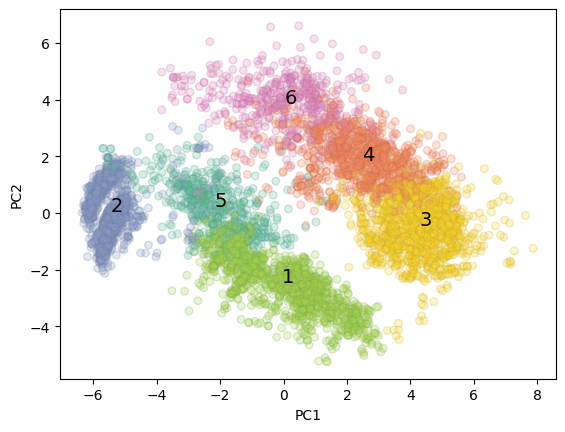

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# run kmeans
for count in [2]:
    cluster = KMeans(n_clusters=6, random_state=count, n_init='auto').fit_predict(data)
    std_dev_clusters = pd.Series(cluster).value_counts().std()
    db_index = davies_bouldin_score(data, cluster)
    sil_score = silhouette_score(data, cluster)
    print(f'count: {count}, std_dev_clusters: {std_dev_clusters}, sil_score: {sil_score}, db_index: {db_index}')
    if sil_score > 0.25:
        break

cycpeptmpdb_regression_df['cluster'] = cluster

### PLOTTING

# Create a custom colormap
oldcmp = plt.get_cmap('Set2')
newcmp = ListedColormap(oldcmp.colors[:6])

# Function to darken colors
def darken_color(color, amount=0.8):
    c = np.array(color)
    return np.clip(c * amount, 0, 1)

# Extract the colors from the colormap and darken them
cluster_indices = cycpeptmpdb_regression_df['cluster'] / cycpeptmpdb_regression_df['cluster'].max()
colors = newcmp(cluster_indices)
dark_colors = [darken_color(color) for color in colors]

cycpeptmpdb_regression_df['x'] = cycpeptmpdb_regression_df['embeddings_pca'].apply(lambda x: x[0])
cycpeptmpdb_regression_df['y'] = cycpeptmpdb_regression_df['embeddings_pca'].apply(lambda x: x[1])

# Plot the scatter plot with darkened edgecolors
plt.scatter(cycpeptmpdb_regression_df['x'], cycpeptmpdb_regression_df['y'], alpha=0.25, c=cycpeptmpdb_regression_df['cluster'], cmap=newcmp, s=30, edgecolors=dark_colors)
# plt.scatter(cycpeptmpdb_regression_df['x'], cycpeptmpdb_regression_df['y'], alpha=0.25, c=cycpeptmpdb_regression_df['SMILES_length'])

# sns.kdeplot(x='x', y='y', hue='cluster', data=cycpeptmpdb_regression_df, fill=False, alpha=0.5, palette=newcmp)

# change cluster 4 to 1
cycpeptmpdb_regression_df['cluster'] = cycpeptmpdb_regression_df['cluster'].replace(4, 7)
# change cluster 2 to 2
cycpeptmpdb_regression_df['cluster'] = cycpeptmpdb_regression_df['cluster'].replace(2, 8)
# change cluster 5 to 3
cycpeptmpdb_regression_df['cluster'] = cycpeptmpdb_regression_df['cluster'].replace(5, 9)
# change cluster 1 to 4
cycpeptmpdb_regression_df['cluster'] = cycpeptmpdb_regression_df['cluster'].replace(1, 10)
# change cluster 0 to 5
cycpeptmpdb_regression_df['cluster'] = cycpeptmpdb_regression_df['cluster'].replace(0, 11)
# change cluster 3 to 6
cycpeptmpdb_regression_df['cluster'] = cycpeptmpdb_regression_df['cluster'].replace(3, 12)
# subtract 6 from cluster number
cycpeptmpdb_regression_df['cluster'] = cycpeptmpdb_regression_df['cluster'] - 6
print(cycpeptmpdb_regression_df['cluster'].value_counts())

# Find cluster centers for PCA
cluster_centers = []
for i in range(10):
    cluster_center = cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['cluster'] == i][['x', 'y']].mean()
    cluster_centers.append(cluster_center)

# Add cluster centers with numbers
for i, txt in enumerate(cluster_centers):
    
    plt.annotate(i, (txt[0], txt[1]), fontsize=14)

# Add labels PCA 1 and PCA 2
plt.xlabel('PC1')  # Label for the x-axis
plt.ylabel('PC2')  # Label for the y-axis

# plt.show()
# Save the plot
plt.savefig('revision/figures/clustering.tif', dpi=300)
plt.savefig('revision/figures/clustering.png', dpi=300)
plt.savefig('revision/figures/clustering.svg')


In [121]:
# split pca_cluster 5 into train, test, and validation sets
kmeans_regression_validation = cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['cluster']==3].reset_index(drop=True)
# len(kmeans_regression_validation)
# make revision folder
import os
if not os.path.exists('revision/training_data/kmeans_regression'):
    os.makedirs('revision/training_data/kmeans_regression')

# save to csv
kmeans_regression_validation[['SMILES', 'PAMPA']].to_csv('revision/training_data/kmeans_regression/kmeans_regression_validation.csv', index=False)


In [119]:
kmeans_train_test = cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['cluster']!=3].reset_index(drop=True)
kmeans_train_test

kmeans_0 = kmeans_train_test[kmeans_train_test['cluster']==0].reset_index(drop=True)
kmeans_1 = kmeans_train_test[kmeans_train_test['cluster']==1].reset_index(drop=True)
kmeans_2 = kmeans_train_test[kmeans_train_test['cluster']==2].reset_index(drop=True)
kmeans_3 = kmeans_train_test[kmeans_train_test['cluster']==4].reset_index(drop=True)
kmeans_4 = kmeans_train_test[kmeans_train_test['cluster']==5].reset_index(drop=True)

# print length of all dataframes
print(len(kmeans_0), len(kmeans_1), len(kmeans_2), len(kmeans_3), len(kmeans_4), len(kmeans_regression_validation))


535 1206 1465 1546 1455 494


In [122]:
# train 1
train_1 = pd.concat([kmeans_0, kmeans_1, kmeans_2, kmeans_3]).reset_index(drop=True)
train_2 = pd.concat([kmeans_0, kmeans_1, kmeans_2, kmeans_4]).reset_index(drop=True)
train_3 = pd.concat([kmeans_0, kmeans_1, kmeans_3, kmeans_4]).reset_index(drop=True)
train_4 = pd.concat([kmeans_0, kmeans_2, kmeans_3, kmeans_4]).reset_index(drop=True)
train_5 = pd.concat([kmeans_1, kmeans_2, kmeans_3, kmeans_4]).reset_index(drop=True)

test_1 = kmeans_4
test_2 = kmeans_3
test_3 = kmeans_2
test_4 = kmeans_1
test_5 = kmeans_0

# save all
train_1[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/train_1.csv', index=False)
train_2[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/train_2.csv', index=False)
train_3[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/train_3.csv', index=False)
train_4[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/train_4.csv', index=False)
train_5[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/train_5.csv', index=False)

test_1[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/test_1.csv', index=False)
test_2[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/test_2.csv', index=False)
test_3[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/test_3.csv', index=False)
test_4[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/test_4.csv', index=False)
test_5[['SMILES','PAMPA']].to_csv('revision/training_data/kmeans_regression/test_5.csv', index=False)


In [13]:
import pandas as pd
# load all data
train_1 = pd.read_csv('revision/training_data/kmeans_regression/test_1.csv')
train_2 = pd.read_csv('revision/training_data/kmeans_regression/test_2.csv')
train_3 = pd.read_csv('revision/training_data/kmeans_regression/test_3.csv')
train_4 = pd.read_csv('revision/training_data/kmeans_regression/test_4.csv')
train_5 = pd.read_csv('revision/training_data/kmeans_regression/test_5.csv')
validation = pd.read_csv('revision/training_data/kmeans_regression/kmeans_regression_validation.csv')

# print length of all dataframes
print(len(train_1), len(train_2), len(train_3), len(train_4), len(train_5), len(validation))
# sum of all dataframes
print(len(train_1) + len(train_2) + len(train_3) + len(train_4) + len(train_5) + len(validation))

# find average PAMPA value for each set
print(train_2['PAMPA'].mean())
print(train_3['PAMPA'].mean())
print(train_1['PAMPA'].mean())
print(train_4['PAMPA'].mean())
print(train_5['PAMPA'].mean())
print(validation['PAMPA'].mean())

# find average SMILES length for each set
print(train_2['SMILES'].apply(lambda x: len(x)).mean())
print(train_3['SMILES'].apply(lambda x: len(x)).mean())
print(train_1['SMILES'].apply(lambda x: len(x)).mean())
print(train_4['SMILES'].apply(lambda x: len(x)).mean())
print(train_5['SMILES'].apply(lambda x: len(x)).mean())
print(validation['SMILES'].apply(lambda x: len(x)).mean())

# find average of all together
print('Totals:')
print(cycpeptmpdb_regression_df['PAMPA'].mean())
print(cycpeptmpdb_regression_df['SMILES'].apply(lambda x: len(x)).mean())

1455 1546 1465 1206 535 494
6701
-5.572257438551099
-5.903904436860069
-6.008123711340206
-5.798598673300166
-5.059831775700935
-5.287186234817813
125.77943078913324
181.01296928327645
116.15601374570447
134.3117744610282
225.3121495327103
209.99392712550608
Totals:
-5.718212207133264
151.45575287270557


In [16]:
# find number of hits less than -5.5 and greater than/equal to -5.5
print('Number of hits less than -5.5 and greater than/equal to -5.5')
print('all')
print(len(cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['PAMPA'] < -5.5]))
print(len(cycpeptmpdb_regression_df[cycpeptmpdb_regression_df['PAMPA'] >= -5.5]))
print('cluster_1')
print(len(train_2[train_2['PAMPA'] >= -5.5]))
print(len(train_2[train_2['PAMPA'] < -5.5]))
print('cluster_2')
print(len(train_3[train_3['PAMPA'] >= -5.5]))
print(len(train_3[train_3['PAMPA'] < -5.5]))
print('cluster_3')
print(len(train_1[train_1['PAMPA'] >= -5.5]))
print(len(train_1[train_1['PAMPA'] < -5.5]))
print('cluster_4')
print(len(train_4[train_4['PAMPA'] >= -5.5]))
print(len(train_4[train_4['PAMPA'] < -5.5]))
print('cluster_5')
print(len(train_5[train_5['PAMPA'] >= -5.5]))
print(len(train_5[train_5['PAMPA'] < -5.5]))
print('validation')
print(len(validation[validation['PAMPA'] >= -5.5]))
print(len(validation[validation['PAMPA'] < -5.5]))


Number of hits less than -5.5 and greater than/equal to -5.5
all
3847
2854
cluster_1
767
779
cluster_2
515
950
cluster_3
402
1053
cluster_4
413
793
cluster_5
419
116
validation
338
156


In [2]:
import pandas as pd
# load all data
cluster_1 = pd.read_csv('revision/training_data/kmeans_regression/test_2.csv')
cluster_2 = pd.read_csv('revision/training_data/kmeans_regression/test_3.csv')
cluster_3 = pd.read_csv('revision/training_data/kmeans_regression/test_1.csv')
cluster_4 = pd.read_csv('revision/training_data/kmeans_regression/test_4.csv')
cluster_5 = pd.read_csv('revision/training_data/kmeans_regression/test_5.csv')
cluster_6 = pd.read_csv('revision/training_data/kmeans_regression/kmeans_regression_validation.csv')

# print length of all dataframes
print(len(cluster_1), len(cluster_2), len(cluster_3), len(cluster_4), len(cluster_5), len(cluster_6))
# sum of all dataframes
print(len(cluster_1) + len(cluster_2) + len(cluster_3) + len(cluster_4) + len(cluster_5) + len(cluster_6))

# save all
cluster_1.to_csv('revision/training_data/clusters/cluster_1.csv', index=False)
cluster_2.to_csv('revision/training_data/clusters/cluster_2.csv', index=False)
cluster_3.to_csv('revision/training_data/clusters/cluster_3.csv', index=False)
cluster_4.to_csv('revision/training_data/clusters/cluster_4.csv', index=False)
cluster_5.to_csv('revision/training_data/clusters/cluster_5.csv', index=False)
cluster_6.to_csv('revision/training_data/clusters/cluster_6.csv', index=False)


1546 1465 1455 1206 535 494
6701


In [2]:
import pandas as pd

# load all clusters
cluster_1 = pd.read_csv('revision/training_data/clusters/cluster_1.csv')
cluster_2 = pd.read_csv('revision/training_data/clusters/cluster_2.csv')
cluster_3 = pd.read_csv('revision/training_data/clusters/cluster_3.csv')
cluster_4 = pd.read_csv('revision/training_data/clusters/cluster_4.csv')
cluster_5 = pd.read_csv('revision/training_data/clusters/cluster_5.csv')
cluster_6 = pd.read_csv('revision/training_data/clusters/cluster_6.csv')

# add cluster column to each dataframe
cluster_1['cluster'] = 1
cluster_2['cluster'] = 2
cluster_3['cluster'] = 3
cluster_4['cluster'] = 4
cluster_5['cluster'] = 5
cluster_6['cluster'] = 6

# concatenate all dataframes
all_clusters = pd.concat([cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]).reset_index(drop=True)
all_clusters
# save to csv
all_clusters.to_csv('revision/training_data/clusters/all_clusters.csv', index=False)



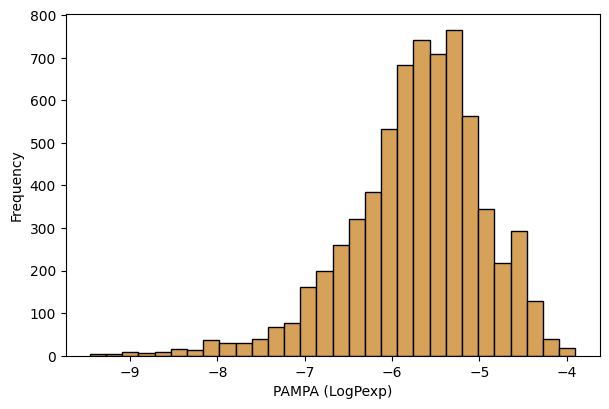

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load all clusters
all_clusters = pd.read_csv('revision/training_data/clusters/all_clusters.csv')

# plot PAMPA distribution
plt.figure(figsize=(6, 4))
plt.hist(all_clusters['PAMPA'], bins=30, edgecolor='black', color='#d6a25a')
# remove whitespace
plt.tight_layout()

# sns.kdeplot(all_clusters['PAMPA'], fill=True)
# add outline
# plt.title('PAMPA Distribution')
plt.xlabel('PAMPA (LogPexp)')
plt.ylabel('Frequency')
# plt.show()
# save
plt.savefig('revision/figures/PAMPA_distribution.tif', dpi=300, bbox_inches='tight')
plt.savefig('revision/figures/PAMPA_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig('revision/figures/PAMPA_distribution.svg', bbox_inches='tight')
